Interpreting how predictors impact target prediction of RandomForest Classifiers/Regressors is
not straightforward. Here's a 2 yr old thread on stackoverflow about [interpreting decision trees](https://stackoverflow.com/questions/48909418/lime-vs-treeinterpreter-for-interpreting-decision-tree/48975492)

Default scikit-learn RF feature importance values are not great, better is [permutation_importance](https://explained.ai/rf-importance/#4)

There are a couple different things I've found:

* treeinterpreter: http://blog.datadive.net/random-forest-interpretation-with-scikit-learn/
 * Seems cool, but it's abandoned (5yrs no updates, py2.7 required)
 * [Implementing treeinterpreter(https://medium.com/@garg.mohit851/random-forest-visualization-3f76cdf6456f)
* [lime](https://lime-ml.readthedocs.io/en/latest/index.html) (Local Interpretable Model-Agnostic Explanations)
 * Also cool, not super straightforward. Better docs, up to date. [github](https://github.com/marcotcr/lime)

* [Shap looks promising](https://github.com/slundberg/shap)
 
Visualising decision trees:
* https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c

* [Python libraries for interpreting ML models](https://www.analyticsvidhya.com/blog/2020/03/6-python-libraries-interpret-machine-learning-models/)

In [20]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import PIED

from collections import Counter
from IPython.display import display
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report,confusion_matrix,plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

dat_df = pd.read_csv("/home/isaac/PIED/jupyter-notebooks/default_PIED/multipleTesting_PiSpRateSlope.csv", header=0)
# Replace abundance scaling "None" with 1, i.e. No abundance scaling is Nc == Ne
dat_df = dat_df.replace("None", 1)
Counter(dat_df["growth_rate_sigma"])
len(dat_df)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


437400

## Train an RF to classify positive/negative/zero slopes

In [21]:
mask = dat_df["sign"].isna()
dat_df["sign"][mask] = 'failed'

## Downsample each category so they are equal numbers (y_neg has ~8500 sims)
nsamps = 8500
keep = []
for val in ["positive", "negative", "zero", "failed"]:
    idx = dat_df.index[dat_df['sign'] == val].tolist()
    idx = np.random.choice(idx, size=nsamps, replace=False)
    keep.extend(idx.tolist())
mask = np.full(len(dat_df), False)
dat_df = dat_df.iloc[keep]

# -5 is the abundance_scaling parameter, which takes values '0.12',
# '1', and 'log', so it's not clear how to encode this for the RF
X = dat_df.iloc[:, 2:-5]
# Drop all the invariable features
X = X.drop("stop_criterion", axis=1)
X = X.drop("ClaDS", axis=1)
X = X.drop("ntaxa", axis=1)
X = X.drop("time", axis=1)
X = X.drop("sequence_length", axis=1)
X = X.drop("sample_size", axis=1)
# 'process' can be abundance or rate, but we'll ignore it for now
X = X.drop("process", axis=1)

# Get the targets: piSpRateSlope, failed, failedPi, sign
# In this analysis 'failed' and 'failedPi' are both invariable and 0, because we removed all failed sims above
y = dat_df.iloc[:, -4:]
y_pos = y[y["sign"] == "positive"]
y_neg = y[y["sign"] == "negative"]
y_zer = y[y["sign"] == "zero"]
y_fail = y[y["sign"] == "failed"]
print(len(y_pos), len(y_neg), len(y_zer), len(y_fail))

/home/isaac/miniconda2/envs/PIED/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


8500 8500 8500 8500


In [22]:
keep = []
for val in ["positive", "negative", "zero", "failed"]:
    idx = dat_df.index[dat_df['sign'] == val].tolist()
    idx = np.random.choice(idx, size=nsamps, replace=False)
    keep.extend(idx.tolist())
mask = np.full(len(dat_df), False)
print(keep[:10])
print(len(keep), len(dat_df))
dat_df.loc[keep]

[409487, 418933, 413389, 284135, 170548, 16488, 405188, 373020, 413800, 425658]
34000 34000


,analysis,sim,birth_rate,stop_criterion,ntaxa,time,process,ClaDS,abundance_mean,abundance_sigma,growth_rate_mean,growth_rate_sigma,ClaDS_sigma,ClaDS_alpha,sequence_length,mutation_rate,sample_size,abundance_scaling,piSpRateSlope,failed,failedPi,sign
409487,mTest37350,sim43,2.00,taxa,200,20,rate,True,2000000,0.0002,0.00002,0.00200,0.10,0.7,1000,1.000000e-06,5,1,0.742122,0,0.0,positive
418933,mTest37539,sim4,2.00,taxa,200,20,rate,True,2000000,0.0002,0.00020,0.00020,0.26,0.7,1000,1.000000e-06,5,1,0.710206,0,0.0,positive
413389,mTest37428,sim45,2.00,taxa,200,20,rate,True,2000000,0.0002,0.00020,0.00002,0.10,0.7,1000,1.000000e-07,5,1,0.062296,0,0.0,positive
284135,mTest24637,sim41,0.20,taxa,200,20,rate,True,2000000,0.0002,0.00200,0.00020,0.10,0.9,1000,1.000000e-07,5,0.12,0.052717,0,0.0,positive
170548,mTest17505,sim8,0.20,taxa,200,20,abundance,True,2000000,0.0002,0.00002,0.00002,0.10,0.7,1000,1.000000e-06,5,1,5.541225,0,0.0,positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94069,mTest09172,sim27,0.02,taxa,200,20,rate,True,200000,0.0002,0.00020,0.00200,0.10,1.1,1000,1.000000e-08,5,0.12,NaN,1,NaN,failed
401850,mTest37198,sim1,2.00,taxa,200,20,rate,True,2000000,0.0002,0.00002,0.00002,0.10,1.1,1000,1.000000e-08,5,0.12,NaN,0,1.0,failed
52843,mTest06889,sim49,0.02,taxa,200,20,rate,True,20000,0.0002,0.00020,0.00020,0.10,0.7,1000,1.000000e-07,5,0.12,NaN,1,NaN,failed
70747,mTest07247,sim7,0.02,taxa,200,20,rate,True,20000,0.0002,0.00200,0.00200,0.26,0.9,1000,1.000000e-08,5,log,NaN,0,1.0,failed


In [137]:
X.describe()

,birth_rate,ntaxa,time,abundance_mean,abundance_sigma,growth_rate_mean,growth_rate_sigma,ClaDS_sigma,ClaDS_alpha,sequence_length,mutation_rate,sample_size
count,113752.000000,113752.0,113752.0,1.137520e+05,113752.000000,113752.000000,113752.000000,113752.000000,113752.000000,113752.0,1.137520e+05,113752.0
mean,0.843887,200.0,20.0,1.102193e+06,0.002255,0.000542,0.000439,0.251143,0.896990,1000.0,5.686983e-07,5.0
std,0.911689,0.0,0.0,9.272882e+05,0.005775,0.000828,0.000758,0.126236,0.159934,0.0,4.618144e-07,0.0
min,0.020000,200.0,20.0,2.000000e+04,0.000200,0.000020,0.000020,0.100000,0.700000,1000.0,1.000000e-08,5.0
25%,0.200000,200.0,20.0,2.000000e+05,0.000200,0.000020,0.000020,0.100000,0.700000,1000.0,1.000000e-07,5.0
50%,0.200000,200.0,20.0,2.000000e+06,0.000200,0.000020,0.000020,0.260000,0.900000,1000.0,1.000000e-06,5.0
75%,2.000000,200.0,20.0,2.000000e+06,0.000200,0.000200,0.000200,0.410000,1.100000,1000.0,1.000000e-06,5.0
max,2.000000,200.0,20.0,2.000000e+06,0.020000,0.002000,0.002000,0.410000,1.100000,1000.0,1.000000e-06,5.0


In [23]:
feature_list = X.columns
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.25)

In [24]:
rfc = RandomForestClassifier(n_estimators=1000, n_jobs=-1, min_samples_leaf=10)
rfc.fit(train_X, train_y["sign"])

RandomForestClassifier(min_samples_leaf=10, n_estimators=1000, n_jobs=-1)

In [25]:
predictions = rfc.predict(test_X)

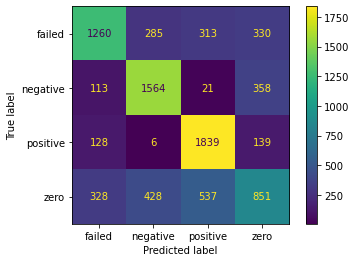

In [26]:
plot_confusion_matrix(rfc, test_X, test_y["sign"])


In [27]:
print(classification_report(test_y["sign"], predictions))

              precision    recall  f1-score   support

      failed       0.69      0.58      0.63      2188
    negative       0.69      0.76      0.72      2056
    positive       0.68      0.87      0.76      2112
        zero       0.51      0.40      0.45      2144

    accuracy                           0.65      8500
   macro avg       0.64      0.65      0.64      8500
weighted avg       0.64      0.65      0.64      8500



In [28]:
print("RF train accuracy: %0.3f" % rfc.score(train_X, train_y["sign"]))
print("RF test accuracy: %0.3f" % rfc.score(test_X, test_y["sign"]))

RF train accuracy: 0.674
RF test accuracy: 0.649


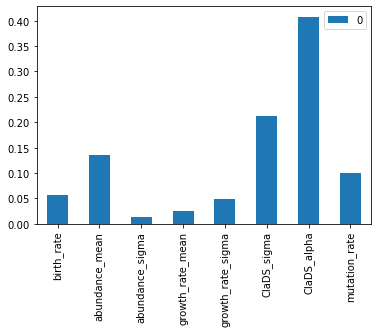

In [29]:
imp_df = pd.DataFrame(rfc.feature_importances_, index=feature_list)
imp_df.plot.bar()

Text(0.5, 1.0, 'Permutation Importances (test set)')

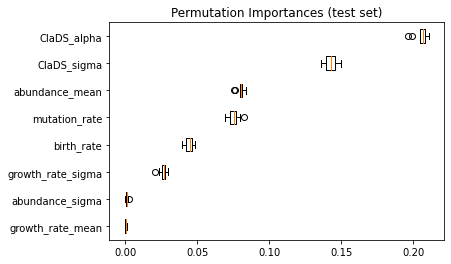

In [30]:
result = permutation_importance(rfc, test_X, test_y["sign"], n_repeats=10, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=test_X.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")

In [31]:
from lime import lime_tabular
explainer = lime_tabular.LimeTabularExplainer(train_X,
                                                   feature_names=train_X.columns,
                                                   class_names=["negative", "positive", "zero", "failed"],
                                                   discretize_continuous=False)
exp = explainer.explain_instance(test_X.iloc[-451, :], rfc.predict_proba, num_features=4, top_labels=3)
exp.available_labels()
exp.show_in_notebook(show_table=True, show_all=True)


## PCA of parameters of predicted labels

In [32]:
pos_predX = test_X[predictions == "positive"]
neg_predX = test_X[predictions == "negative"]
zer_predX = test_X[predictions == "zero"]
fail_predX = test_X[predictions == "failed"]
print(len(pos_predX), len(neg_predX), len(zer_predX), len(fail_predX))

# Map labels to ints so we can color the plot
colors = np.copy(predictions)
colors[colors == "positive"] = "red"
colors[colors == "negative"] = "blue"
colors[colors == "zero"] = "yellow"
colors[colors == "failed"] = "black"
colors

2710 2283 1678 1829


array(['blue', 'black', 'black', ..., 'black', 'blue', 'blue'],
      dtype=object)

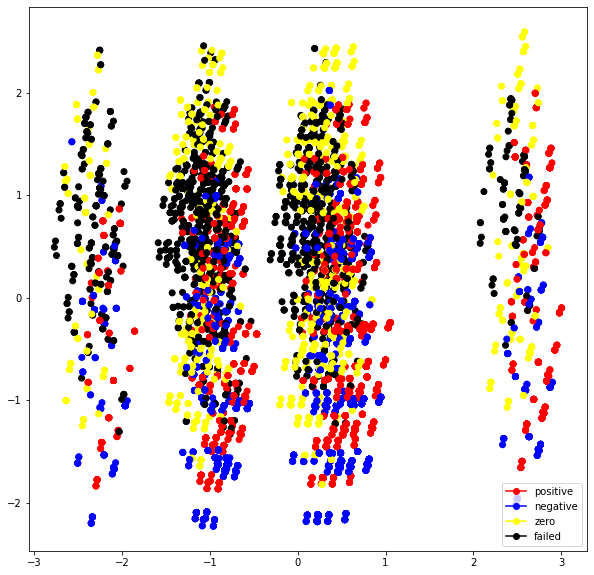

In [45]:
from matplotlib.lines import Line2D

scaler = StandardScaler()
scaled_X = scaler.fit_transform(test_X)
fig, ax = plt.subplots(figsize=(10, 10))

pca = PCA(n_components=5)
scaled_X = pca.fit_transform(scaled_X)

plt.scatter(scaled_X[:, 0], scaled_X[:, 1], c=colors)


legend_elements = [Line2D([0], [0], marker='o', color='red', label='positive'),
                    Line2D([0], [0], marker='o', color='blue', label='negative'),
                    Line2D([0], [0], marker='o', color='yellow', label='zero'),
                    Line2D([0], [0], marker='o', color='black', label='failed')]
ax.legend(handles=legend_elements)

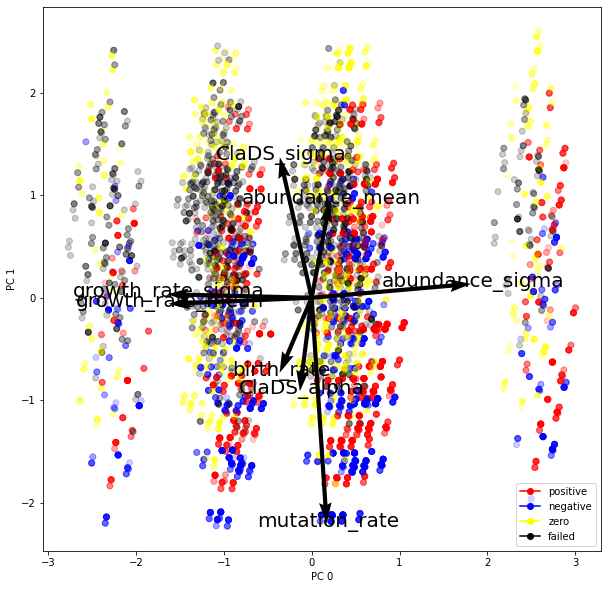

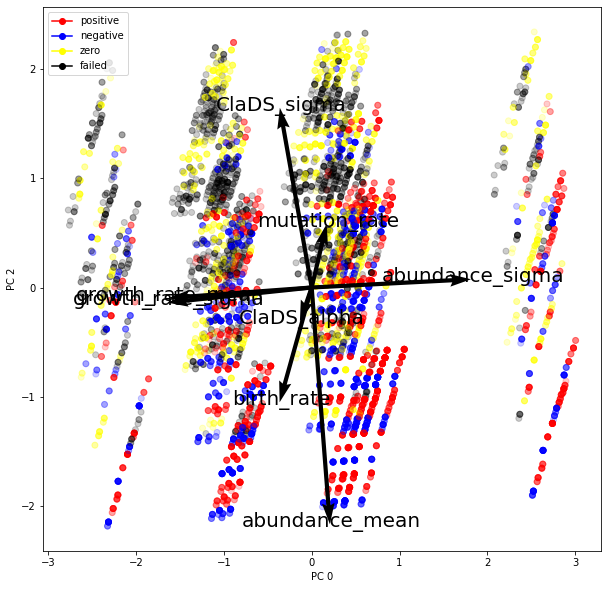

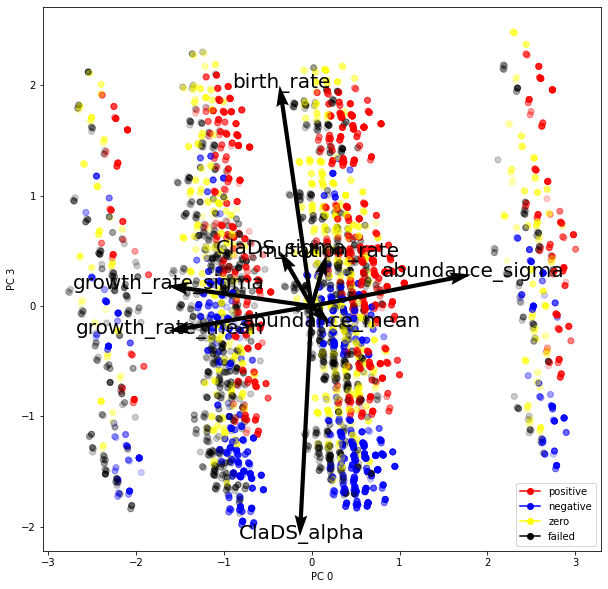

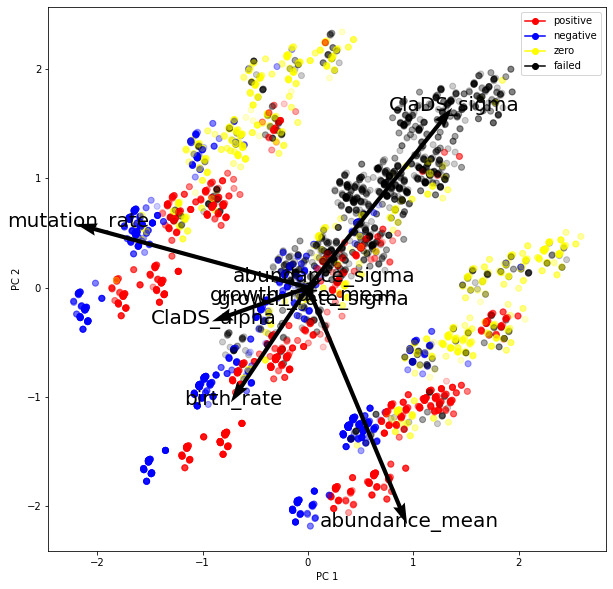

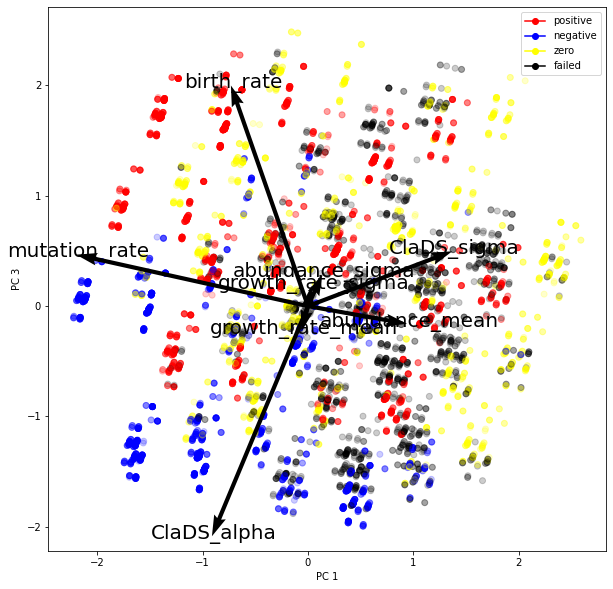

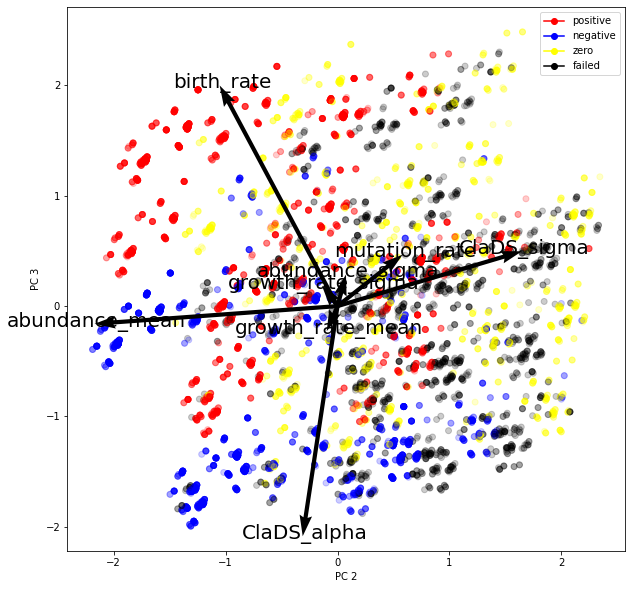

In [48]:
def plot_pcs(first, second):
    adjust = 3
    PCs = pca.components_

    # Use quiver to generate the basic plot
    fig = plt.figure(figsize=(10,10))
    plt.scatter(scaled_X[:, first], scaled_X[:, second], c=colors, alpha=0.2)
    ax.legend(handles=legend_elements)

    plt.quiver(np.zeros(PCs.shape[1]), np.zeros(PCs.shape[1]),
               PCs[first,:]*adjust, PCs[second,:]*adjust, 
               angles='xy', scale_units='xy', scale=1)

    # Add labels based on feature names (here just numbers)
    feature_names = test_X.columns
    for i,j,z in zip(PCs[second,:]*adjust+0.02, PCs[first,:]*adjust+0.02, feature_names):
        plt.text(j, i, z, ha='center', va='center', size=20)

    # Ensure correct aspect ratio and axis limits
    #plt.axis('equal')
    #plt.xlim([-1.0,1.0])
    #plt.ylim([-1.0,1.0])

    # Label axes
    plt.xlabel('PC {}'.format(first))
    plt.ylabel('PC {}'.format(second))
    plt.legend(handles=legend_elements)
plot_pcs(0, 1)
plot_pcs(0, 2)
plot_pcs(0, 3)
plot_pcs(1, 2)
plot_pcs(1, 3)
plot_pcs(2, 3)

In [167]:
print(test_X.columns)
PCs


Index(['birth_rate', 'abundance_mean', 'abundance_sigma', 'growth_rate_mean',
       'growth_rate_sigma', 'ClaDS_sigma', 'ClaDS_alpha', 'mutation_rate'],
      dtype='object')


array([[-0.17442635,  0.02478864,  0.6005255 , -0.5428039 , -0.55350261,
        -0.02958965, -0.07000203,  0.03940884],
       [ 0.17580198,  0.57482838, -0.00810124, -0.10743678,  0.06251996,
         0.11363206, -0.39327321, -0.6749614 ],
       [-0.24195984, -0.50260794,  0.03032151, -0.0009789 ,  0.07117471,
         0.74955518, -0.29276683, -0.18790721]])

# Useless below here

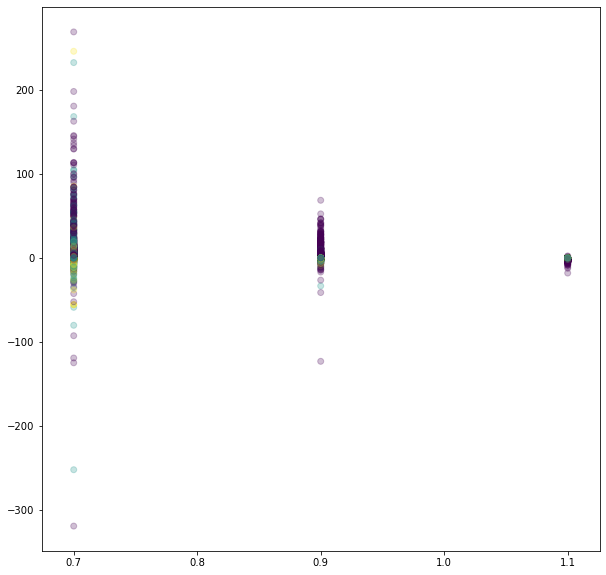

In [102]:
fig, ax = plt.subplots(figsize=(10, 10))
_ = plt.scatter(X["ClaDS_alpha"], y["piSpRateSlope"], c=(X["ClaDS_sigma"]), alpha=0.25)

#_ = plt.scatter(X["mutation_rate"], y["piSpRateSlope"], c=(X["ClaDS_sigma"]), cmap="rainbow", s=50, alpha=0.5)
#ax.set_xlim(0, 0.000001)


(-10, 10)

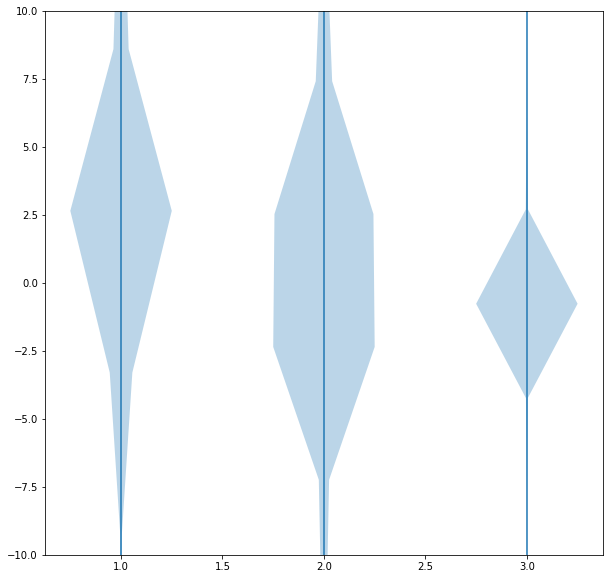

In [330]:
fig, ax = plt.subplots(figsize=(10, 10))
data_to_plot = [y["piSpRateSlope"][X["ClaDS_sigma"]==0.1].values,
                y["piSpRateSlope"][X["ClaDS_sigma"]==0.26].values,
                y["piSpRateSlope"][X["ClaDS_sigma"]==0.41].values]
_ = ax.violinplot(data_to_plot)
ax.set_ylim(-10, 10)

(-10, 10)

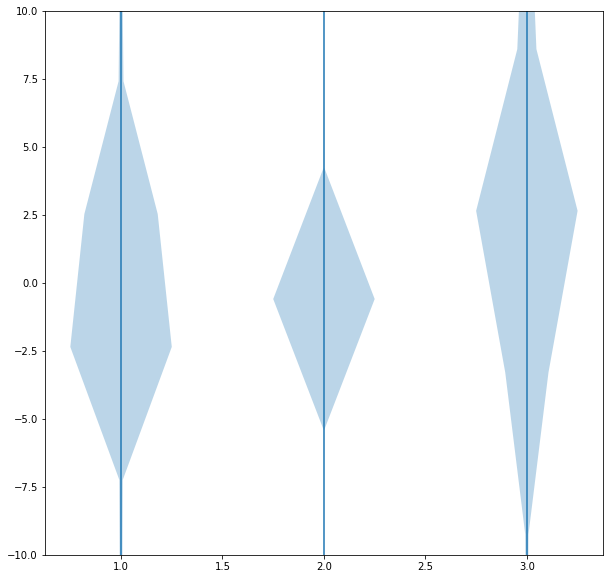

In [331]:
fig, ax = plt.subplots(figsize=(10, 10))
data_to_plot = [y["piSpRateSlope"][X["mutation_rate"]==1e-8].values,
                y["piSpRateSlope"][X["mutation_rate"]==1e-7].values,
                y["piSpRateSlope"][X["mutation_rate"]==1e-6].values]
_ = ax.violinplot(data_to_plot)
ax.set_ylim(-10, 10)

In [196]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
_ = ax.plot(X["ClaDS_alpha"], X["ClaDS_sigma"], y["piSpRateSlope"], color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
ax.view_init(elev=28, azim=120)
ax.set_xlabel('ClaDS_alpha', fontsize=12)
ax.set_ylabel('ClaDS_sigma', fontsize=12)
ax.set_zlabel('piSpRateSlope', fontsize=12)


ValueError: 'transform' must be an instance of 'matplotlib.transform.Transform'

# RF Regression on the slope

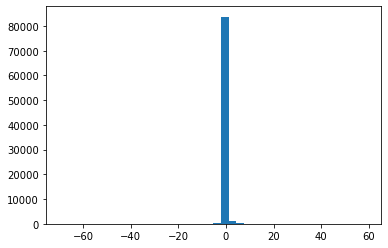

In [270]:
scaler = StandardScaler()
scaler.fit(train_y["piSpRateSlope"].values.reshape(-1, 1))
y_train = scaler.transform(train_y["piSpRateSlope"].values.reshape(-1, 1))
y_test = scaler.transform(test_y["piSpRateSlope"].values.reshape(-1, 1))
_ = plt.hist(y_train, bins=40)

In [268]:
rf = RandomForestRegressor(n_estimators=1000)
rf.fit(train_X, y_train.ravel())

RandomForestRegressor(n_estimators=1000)

In [271]:
predictions = rf.predict(test_X)

[-0.0448321  -0.01517412 -0.04486401 ... -0.04608484 -0.0469161
 -0.01155952]
Mean Absolute Error: 0.19


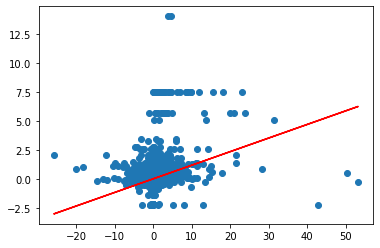

In [272]:
from sklearn.linear_model import LinearRegression

print(predictions)
errors = abs(predictions - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2))
plt.scatter(y_test, predictions)

linear_regressor = LinearRegression()
linear_regressor.fit(y_test.reshape(-1, 1), predictions.reshape(-1, 1))
Y_pred = linear_regressor.predict(y_test.reshape(-1, 1))
plt.plot(y_test.reshape(-1, 1), Y_pred, color='red')


In [274]:
print("RF train accuracy: %0.3f" % rf.score(train_X, y_train))
print("RF test accuracy: %0.3f" % rf.score(test_X, y_test))

RF train accuracy: 0.130
RF test accuracy: 0.061


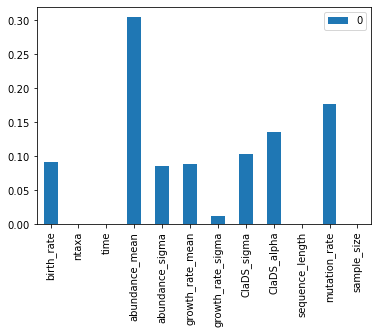

In [275]:
imp_df = pd.DataFrame(rf.feature_importances_, index=feature_list)
imp_df.plot.bar()

Text(0.5, 1.0, 'Permutation Importances (test set)')

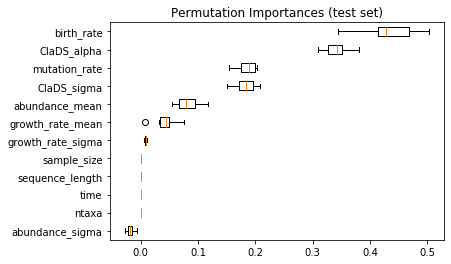

In [232]:
result = permutation_importance(rf, test_X, test_y["piSpRateSlope"], n_repeats=10, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=test_X.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")

Text(0.5, 0, 'piSpRateSlope')

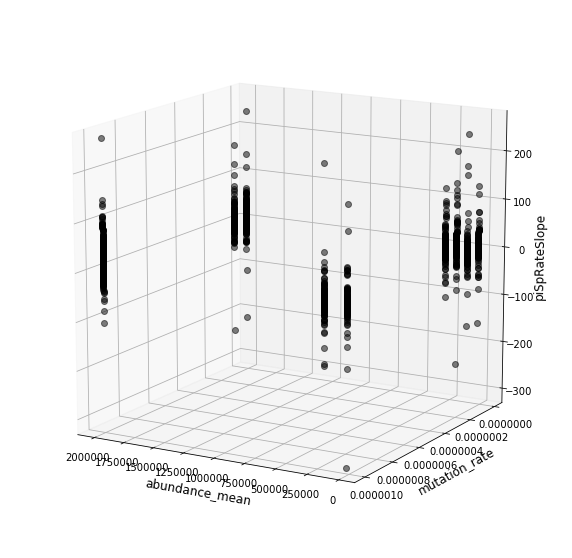

In [206]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
_ = ax.plot(X["abundance_mean"], X["mutation_rate"], y["piSpRateSlope"], color='k', zorder=15, linestyle='none', marker='o', alpha=0.5)
ax.view_init(elev=14, azim=120)
ax.set_xlabel('abundance_mean', fontsize=12)
ax.set_ylabel('mutation_rate', fontsize=12)
ax.set_zlabel('piSpRateSlope', fontsize=12)

# What's with the wacky slopes?

In [220]:
tmp_df = dat_df[dat_df["piSpRateSlope"] > 10]
Counter(tmp_df["sign"])

Counter({'zero': 409, 'positive': 525})

In [195]:
prenames = ["SLH_AL_0036-contemp.clustS:Scaffold_10:44466-44726;size=1;+"]
names = ["SLH_AL_0036-contemp.clustS:Scaffold_10:44466-44726;tag=GCCATTTC;size=1;+"]
reps = [int(n.split(";")[-2][5:]) for n in prenames]
print(reps)
reps = [int(n.split(";")[-2][5:]) for n in names]
print(reps)
print(prenames[0].rsplit(";", 2)[0])
print(names[0].rsplit(";", 2)[0])

names[0].rsplit(":")

rname = names[0].rsplit(";", 2)[0]
print(rname)
chrom, posish = rname.rsplit(":")

[1]
[1]
SLH_AL_0036-contemp.clustS:Scaffold_10:44466-44726
SLH_AL_0036-contemp.clustS:Scaffold_10:44466-44726;tag=GCCATTTC
SLH_AL_0036-contemp.clustS:Scaffold_10:44466-44726;tag=GCCATTTC


ValueError: too many values to unpack (expected 2)

In [52]:
!hostname

goatzilla
